In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.datasets as dsets
import PIL
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(10),
                                     transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                     transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [5]:
transform_test = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [6]:
training_dataset = dsets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
validation_dataset = dsets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
training_loader = DataLoader(dataset=training_dataset,batch_size=100,shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset,batch_size=100,shuffle=False)

In [8]:
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1,2,0)
    img = img * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    img = img.clip(0,1)
    return img

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

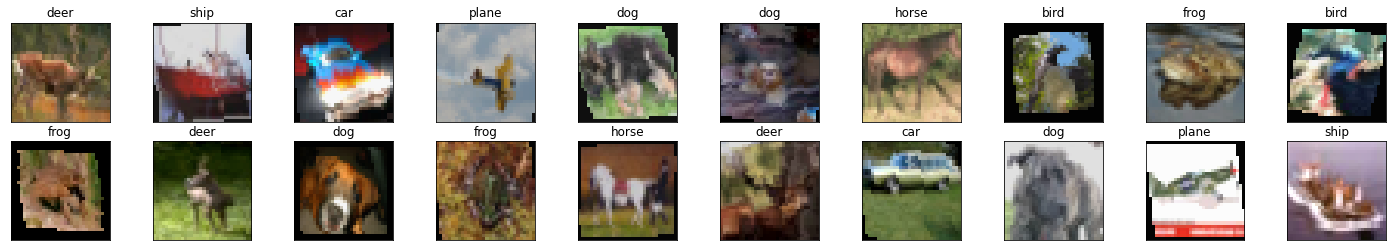

In [10]:
dataiter = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title(classes[labels[i].item()])

In [11]:
class CNN(nn.Module):
    def __init__(self,pool_size=(4,4)):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.conv4 = nn.Conv2d(64,128,3)
        
        self.batch_norm1 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.AdaptiveMaxPool2d(pool_size)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128*pool_size[0]*pool_size[1],500)
        self.fc2 = nn.Linear(500,1000)
        self.fc3 = nn.Linear(1000,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.batch_norm1(x)

        x = self.maxpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)
        

In [12]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): AdaptiveMaxPool2d(output_size=(4, 4))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)

In [13]:
print(summary(model,(3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
            Conv2d-2           [-1, 32, 28, 28]           4,640
            Conv2d-3           [-1, 64, 26, 26]          18,496
            Conv2d-4          [-1, 128, 24, 24]          73,856
       BatchNorm2d-5          [-1, 128, 24, 24]             256
 AdaptiveMaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 500]       1,024,500
            Linear-8                 [-1, 1000]         501,000
            Linear-9                   [-1, 10]          10,010
Total params: 1,633,206
Trainable params: 1,633,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.78
Params size (MB): 6.23
Estimated Total Size (MB): 8.03
---------------------------------------

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs,labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _,preds = torch.max(outputs,1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs,val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs,val_labels)
                
                _,val_preds = torch.max(val_outputs,1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
            epoch_loss = running_loss/len(training_loader)
            epoch_acc = running_corrects.float()/len(training_loader)
            running_loss_history.append(epoch_loss)
            running_corrects_history.append(epoch_acc)
            
            val_epoch_loss = val_running_loss/len(validation_loader)
            val_epoch_acc = val_running_corrects.float()/len(validation_loader)
            val_running_loss_history.append(val_epoch_loss)
            val_running_corrects_history.append(val_epoch_acc)
            
            print('epoch: ',e+1)
            print('training accuracy: {:.4f}, training loss: {:.4f}'.format(epoch_acc.item(),epoch_loss))
            print('validation accuracy: {:.4f}, validation loss: {:.4f}'.format(val_epoch_acc.item(),val_epoch_loss))
        

epoch:  1
training accuracy: 40.8200, training loss: 1.6587
validation accuracy: 53.4500, validation loss: 1.2757
epoch:  2
training accuracy: 54.7660, training loss: 1.2583
validation accuracy: 62.9600, validation loss: 1.0670
epoch:  3
training accuracy: 60.1580, training loss: 1.1215
validation accuracy: 65.3900, validation loss: 0.9884
epoch:  4
training accuracy: 63.4080, training loss: 1.0396
validation accuracy: 67.2800, validation loss: 0.9405
epoch:  5
training accuracy: 65.5140, training loss: 0.9862
validation accuracy: 70.0300, validation loss: 0.8658
epoch:  6
training accuracy: 66.4280, training loss: 0.9611
validation accuracy: 69.9500, validation loss: 0.8598
epoch:  7
training accuracy: 67.2720, training loss: 0.9295
validation accuracy: 71.1900, validation loss: 0.8275
epoch:  8
training accuracy: 68.4660, training loss: 0.9057
validation accuracy: 72.4200, validation loss: 0.7888
epoch:  9
training accuracy: 69.1580, training loss: 0.8835
validation accuracy: 73.7300

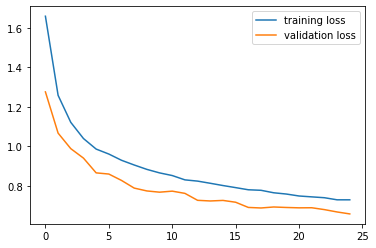

In [16]:
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()
plt.show()

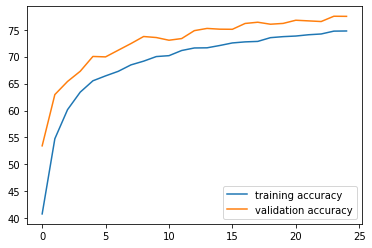

In [17]:
plt.plot(running_corrects_history,label='training accuracy')
plt.plot(val_running_corrects_history,label='validation accuracy')
plt.legend()
plt.show()

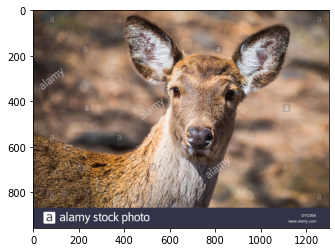

In [18]:
import PIL.ImageOps

import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

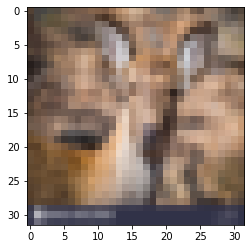

In [20]:
img = transform_test(img)
plt.imshow(im_convert(img))

In [23]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

deer


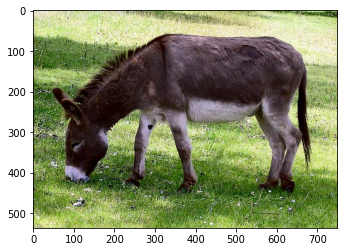

In [33]:
url = 'https://upload.wikimedia.org/wikipedia/commons/1/1a/Donkey_in_Clovelly%2C_North_Devon%2C_England.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

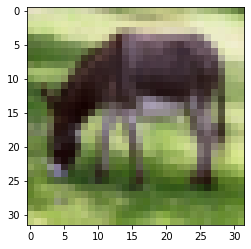

In [34]:
img = transform_test(img)
plt.imshow(im_convert(img))

In [35]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

horse


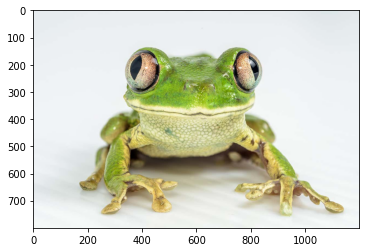

In [36]:
url = 'https://images.newscientist.com/wp-content/uploads/2020/09/22145012/big-frog-eyes.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

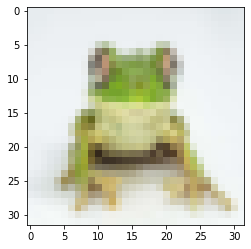

In [37]:
img = transform_test(img)
plt.imshow(im_convert(img))

In [38]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

frog


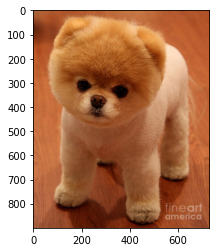

In [39]:
url = 'https://images.fineartamerica.com/images-medium-large-5/pomeranian-puppy-marvin-blaine.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
plt.show()

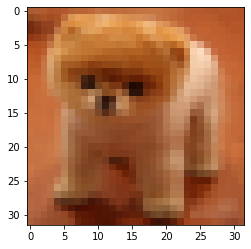

In [40]:
img = transform_test(img)
plt.imshow(im_convert(img))

In [41]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

dog


In [ ]:
dataiter = iter(validation_loader)
images,labels = dataiter.next()
images,labels = images.to(device),labels.to(device)
output = model(images)
_,preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))

for i in np.arange(20):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[i]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
    